In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import fredapi as fa
import requests
import json
import prettytable
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pandas.tseries.frequencies import to_offset



In [2]:
class SectorsOfTheMarket:
    
    def __init__(self):
        self.dict_sectors = {}
        self.dict_plots = {}
        #method calls
        self.get_sector_data()
        self.display_daily_returns(self.dict_sectors)
        self.display_weekly_returns(self.dict_sectors)
        self.display_monthly_returns(self.dict_sectors)
        self.year_to_date_returns(self.dict_sectors)
        self.excel_writer(self.dict_sectors)
        
    def hour_wiper(df):   
            df = df.reset_index()
            df["Date"] = pd.to_datetime(df["Date"]).dt.date
            df = df.set_index('Date')
            return df
    
    def plot_factor(series_factor, x_label, y_label):
        figure = plt.figure()
        plt.plot(series_factor.index, series_factor.values)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        return figure
        
        
    def data_grabber(self, ticker):
        #Function designed to take any ticker and grab annual data
        ticker = yf.Ticker(ticker)
        ticker_data = ticker.history(period = "max", interval = "1d")
        ticker_data = SectorsOfTheMarket.hour_wiper(ticker_data)
        
        if not ticker_data.empty:
            return ticker_data
        else:
            print(f"The associated data for {ticker} is empty")
       
        return ticker_data
    
    def get_sector_data(self):
        list_sectors = ["Market(S&P 500)", "Market Volatility(VIX)","Financial Services Sector", "Technology Sector", "Software Sector", "Internet Sector", "Semiconductors Sector", "Health Care Sector", "Biotechnology Sector", "Pharmaceuticals Sector", "Energy Sector", "Clean Energy Sector", "Real Estate Sector", "Construction Sector", "Industrial Sector", "Consumer Discretionary Sector", "Agriculture Sector", "Consumer Staples Sector", "Utility Sector", "Cyber Security Sector", "ECommerce Sector", "AI sector", "Emerging Tech", "Infrastructure Sector", "Commodities Sector", "United States Oil Fund LP", "Telecommunications Sector", "Basic Materials Sector", "Transportation Sector", "Emerging Markets Sector", "Global Water Sector", "Gaming and eSports Sector"]
        dict_assets = {"S&P 500": "^GSPC", "VIX": "^VIX", "Vanguard Financials Index Fund Index": "VFH", "Technology Select Sector SPDR Fund Index": "XLK", "Vanguard Information Technology": "VGT", "First Trust Dow Jones Internet Index Fund": "FDN", "iShares Semiconductor ETF": "SOXX", "iShares U.S. Healthcare Providers ETF": "IHF", "iShares Biotechnology ETF": "IBB", "VanEck Pharmaceutical ETF": "PPH", "S&P 500 Energy": "^GSPE", "S&P Global Clean Energy Index Price": "ICLN", "JPMorgan BetaBuilders MSCI U.S. REIT ETF Price": "BBRE",  "iShares U.S. Home Construction ETF Price": "ITB", "Dow Jones Industrial Average® Price": "^DJI",  "Consumer Discretionary Select Sector SPDR Fund Price": "XLY", "Invesco DB Agriculture Fund": "DBA", "S&P 500 Consumer Staples": "^SP500-30", "Dow Jones Utility Average": "XAU=F", "First Trust Nasdaq Cybersecurity ETFx Price": "CIBR", "Global X E-Commerce ETF Price": "EBIZ", "Invesco AI and Next Gen Software ETF Price": "IGPT", "BlackRock Future Tech ETF Price": "BTEK", "ProShares DJ Brookfield Global Infrastructure ETF Price": "TOLZ", "Invesco DB Commodity Index Tracking Fund Price": "DBC", "United States Oil Fund LP Price": "USO", "iShares U.S. Telecommunications ETF Price": "IYZ", "iShares U.S. Basic Materials ETF Price": "IYM", "Dow Jones Transportation Average Price": "^DJT", "SPDR S&P Emerging Markets Dividend ETF Price": "EDIV", "Invesco S&P Global Water Index ETF Price": "CGW", "VanEck Video Gaming and eSports ETF": "ESPO"}
        counter = 0
        
        for x in dict_assets:
            ticker = dict_assets[x]
            df_ticker = self.data_grabber(ticker)
            self.dict_sectors[list_sectors[counter]] = df_ticker
            plot = SectorsOfTheMarket.plot_factor(df_ticker, "Year", f"{x} Price",)
            self.dict_plots[list_sectors[counter]] = plot
            counter += 1
        return self.dict_sectors, self.dict_plots

    def multi_index_df(self, dict):
        df = pd.concat(dict.values(), axis = 1, keys=dict.keys())
        return df
    
    def display_daily_returns(self, dict_sectors):
        dict_DTD = {}
        
        for x in dict_sectors:
            df = dict_sectors[x]
            df = df.reset_index()
            df["Date"] = pd.to_datetime(df['Date'])
            df["Day to Day"] = df["Close"].pct_change()
            df = df.set_index(df["Date"])
            dict_DTD[x] = (df["Day to Day"]).dropna()

        df_dailyret = self.multi_index_df(dict_DTD)
        self.heatmap(df_dailyret, "Daily returns of the Sectors of the Market")
    
        return df_dailyret
    
    def display_weekly_returns(self, dict_sectors):
        dict_WTW = {}
        
        for x in dict_sectors:
            df = dict_sectors[x]
            df.index = pd.to_datetime(df.index)
            df_weekly = df.resample('W').first()
            series_weekly_returns = (df_weekly["Close"].pct_change()).dropna()
            dict_WTW[x] = series_weekly_returns
        
        df_weekly_returns = self.multi_index_df(dict_WTW) 
        self.heatmap(df_weekly_returns, "Weekly Returns of the Sectors of the Market")  
            
        return df_weekly_returns
            
    def display_monthly_returns(self, dict_sectors):
        dict_MTM = {}
        
        for x in dict_sectors:
            df = dict_sectors[x]
            df.index = pd.to_datetime(df.index)
            df_monthly = df.resample('M').first()
            series_monthly_returns = (df_monthly["Close"].pct_change()).dropna()
            dict_MTM[x] = series_monthly_returns
        
        df_monthly_returns = self.multi_index_df(dict_MTM) 
        self.heatmap(df_monthly_returns, "Monthly Returns of the Sectors of the Market")    
            
        return df_monthly_returns    
        
    def year_to_date_returns(self, dict_sectors):
        dict_YTD = {}

        for x in dict_sectors:
            df = dict_sectors[x]
            df.index = pd.to_datetime(df.index)
            df_yearly = df.resample('Y').first()
            float_YTD_returns = (df["Close"].iloc[-1] - df_yearly['Close'].iloc[-1]) / df_yearly['Close'].iloc[-1]
            dict_YTD[x] = pd.Series(float_YTD_returns)
            
        df_YTD = self.multi_index_df(dict_YTD) 
        self.heatmap(df_YTD, "Year to Date Returns of the Sectors of the Market") 
        return df_YTD
        
    def heatmap(self, data, title):
        symbol = ((np.asarray(data.iloc[-1].index)))
        most_recent_data = round(data.iloc[-1]*100,6)
        most_recent_data = np.asarray(most_recent_data).reshape(4, 8)
        symbol = np.asarray(symbol).reshape(4, 8)
        labels = (np.asarray(["{0} \n {1:.3f}".format(symbol, per_change) for symbol, per_change in zip(symbol.flatten(), most_recent_data.flatten())])).reshape(4,8)
        fig, ax = plt.subplots(figsize=(30,9))
        plt.title(title,fontsize=18)
        ax.title.set_position([0.5,1.05])
        ax.set_xticks([])
        sns.heatmap(most_recent_data, annot=labels, fmt="", cmap='RdYlGn', ax=ax)
        plt.show()

    def excel_writer(self, dict_sectors):
        writer = pd.ExcelWriter(r"C:\Users\mattp\Quant Finance\SMIF\Data Base\Sectors\All Sectors of the Market.xlsx")
        
        for key in dict_sectors:
            new_dataframe = dict_sectors[key]
            new_dataframe.to_excel(writer, sheet_name=key)
        writer.close()

C:\Users\mattp\AppData\Local\Temp\ipykernel_7188\897445723.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  figure = plt.figure()


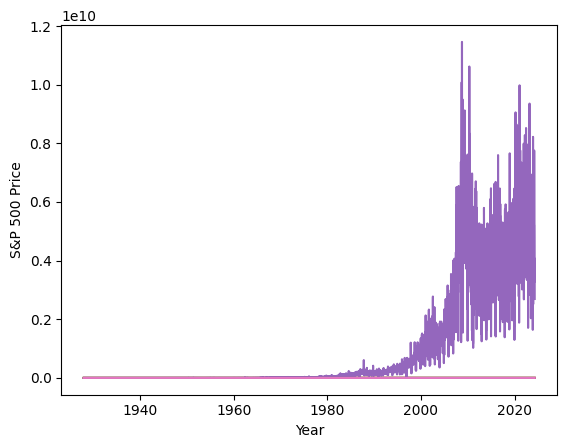

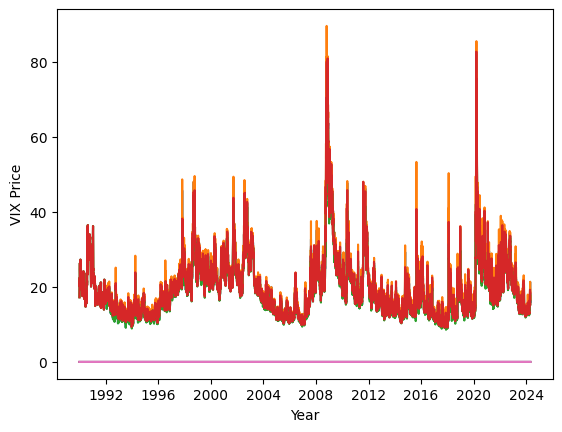

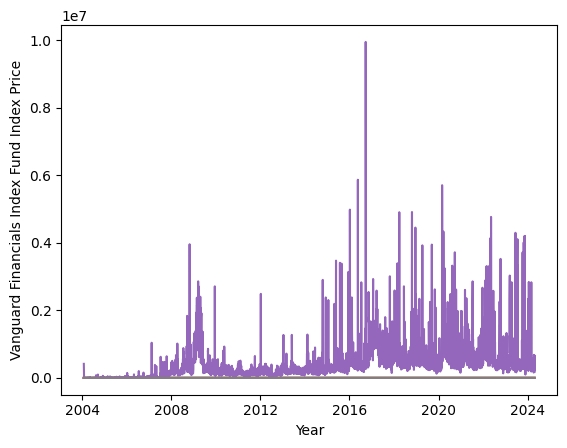

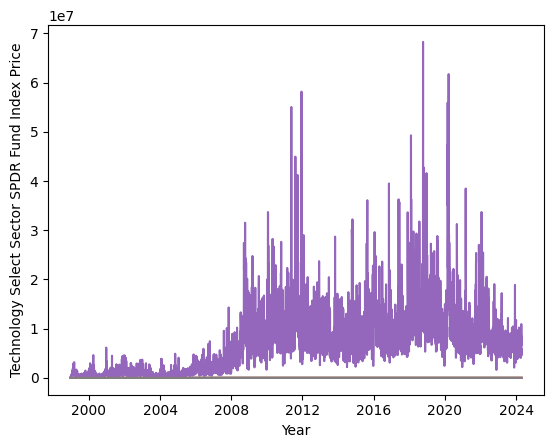

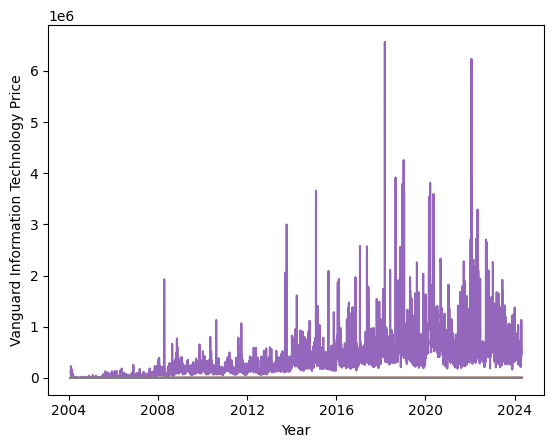

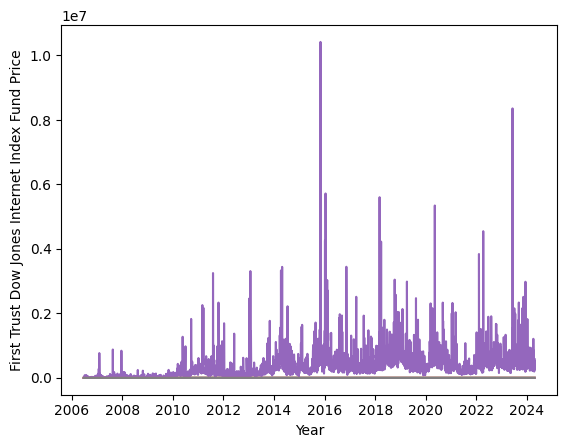

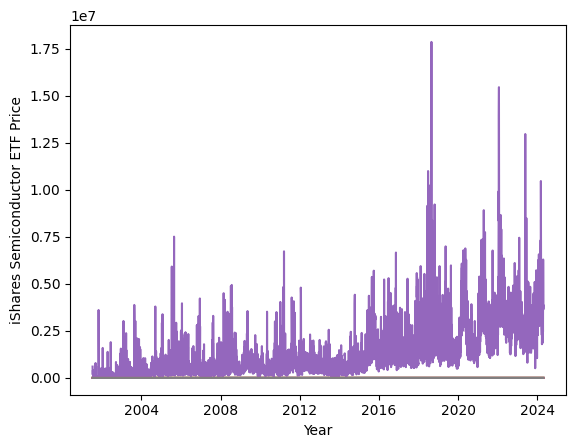

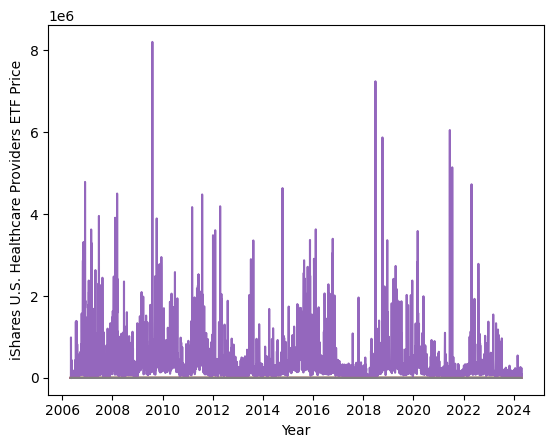

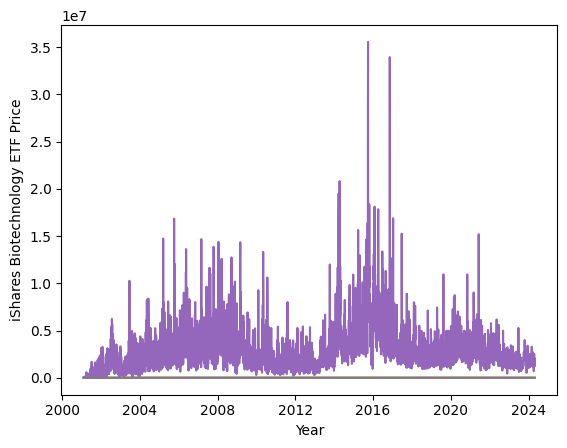

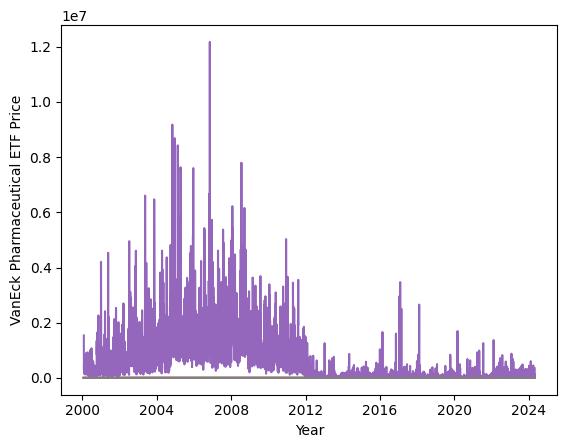

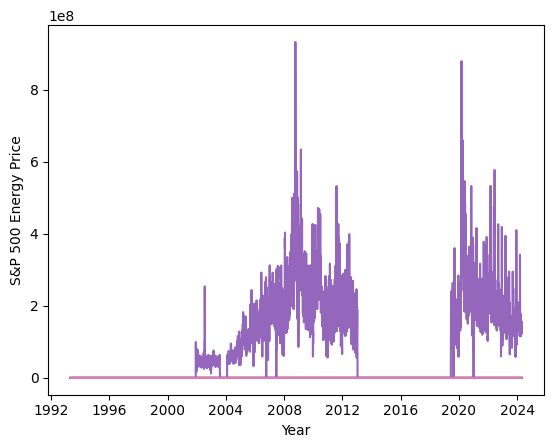

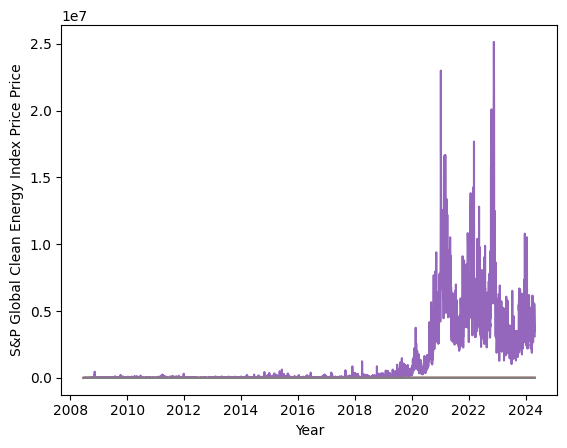

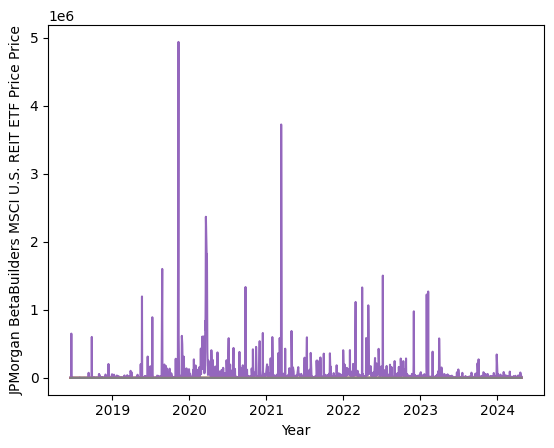

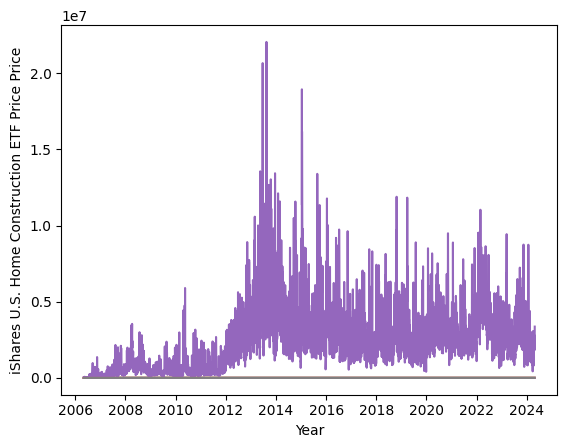

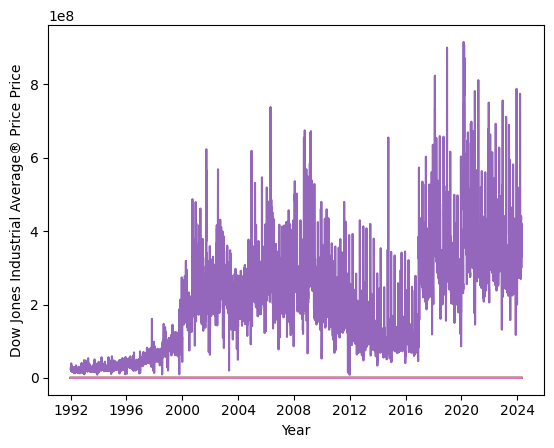

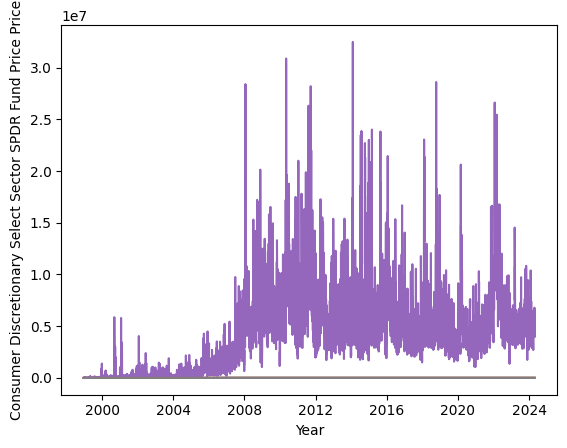

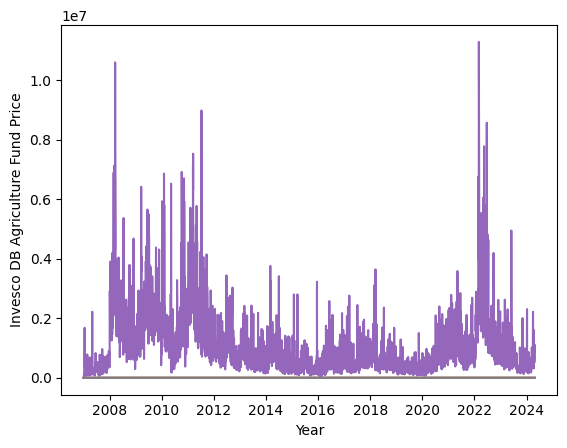

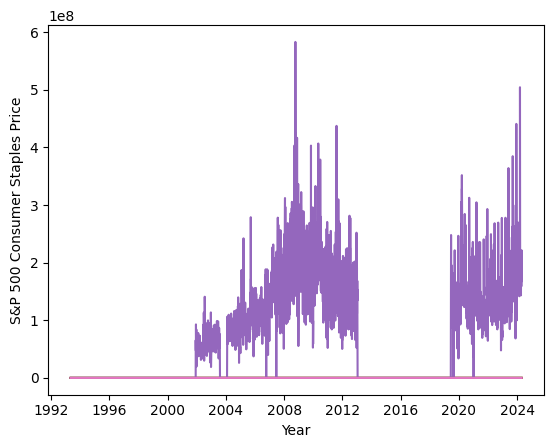

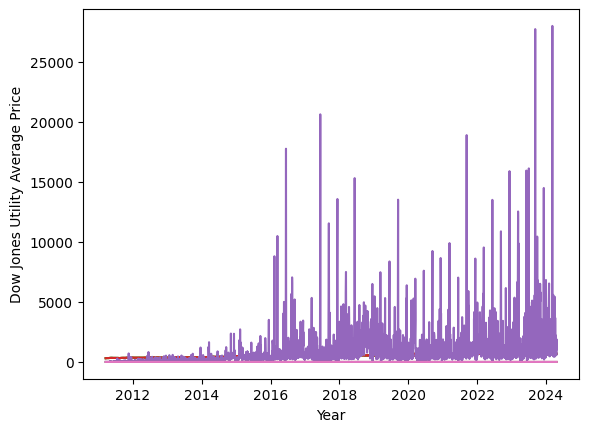

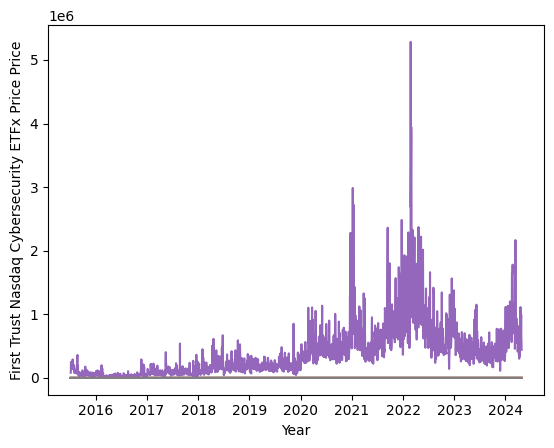

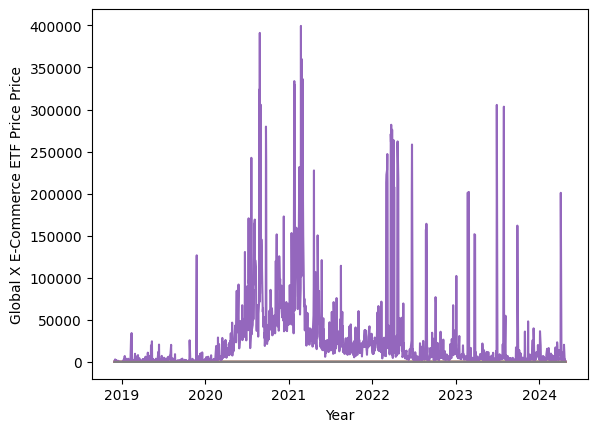

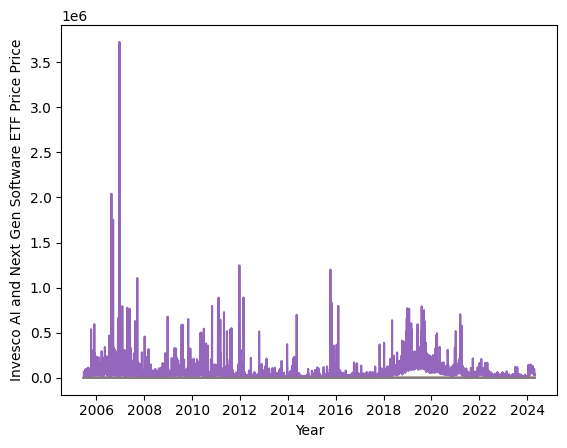

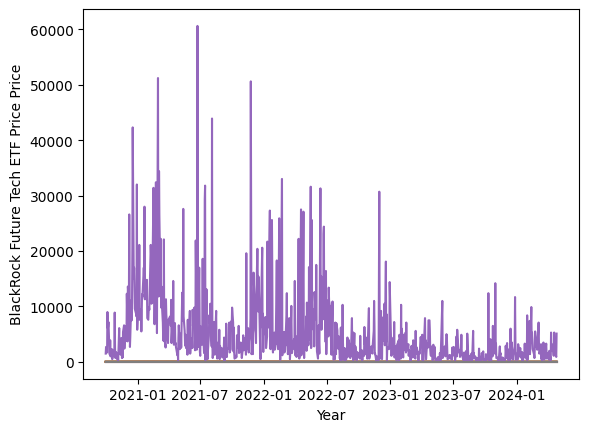

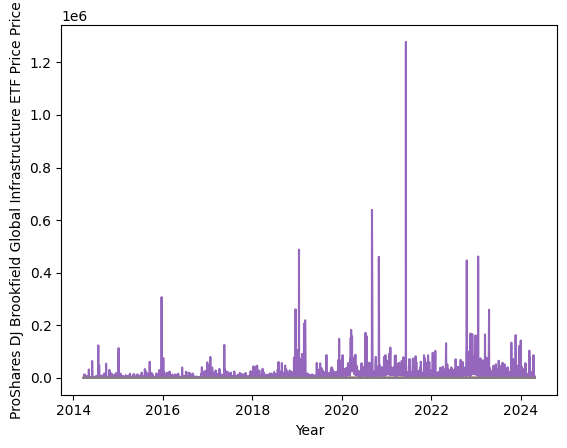

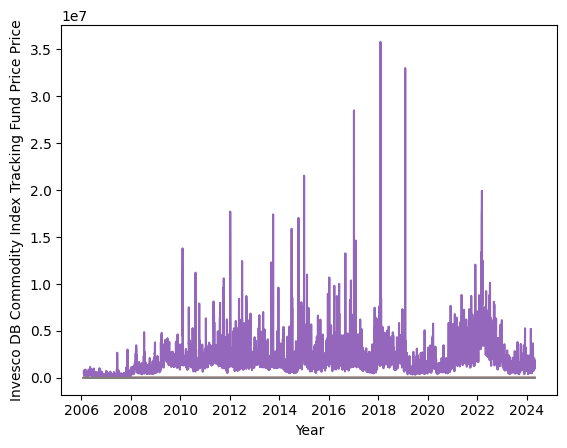

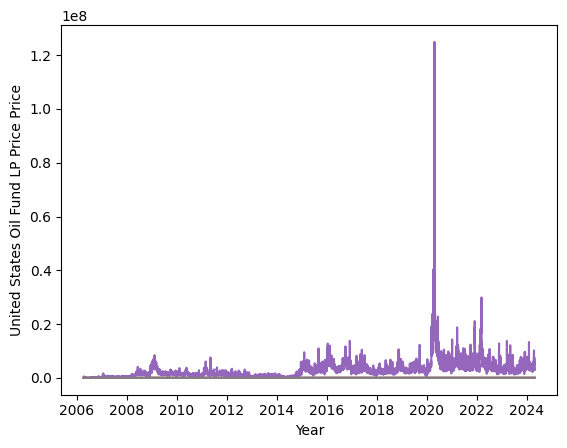

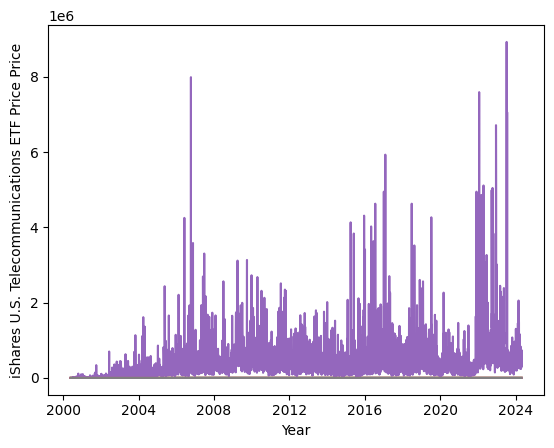

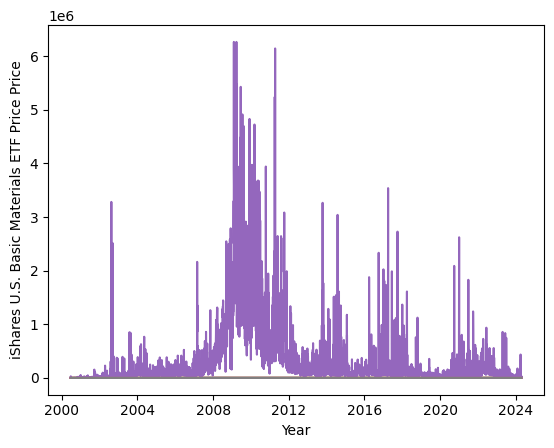

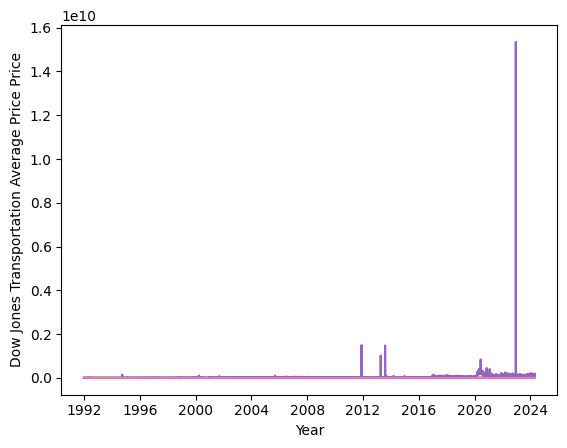

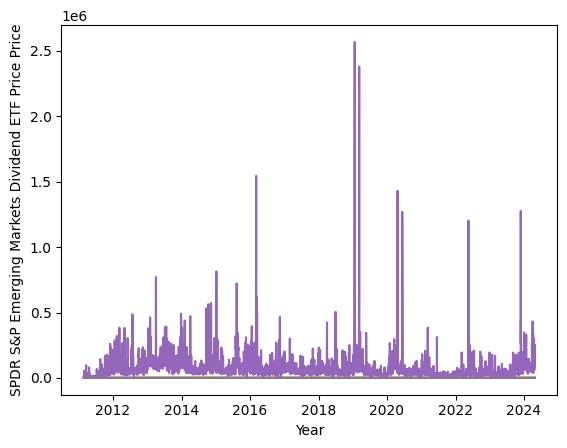

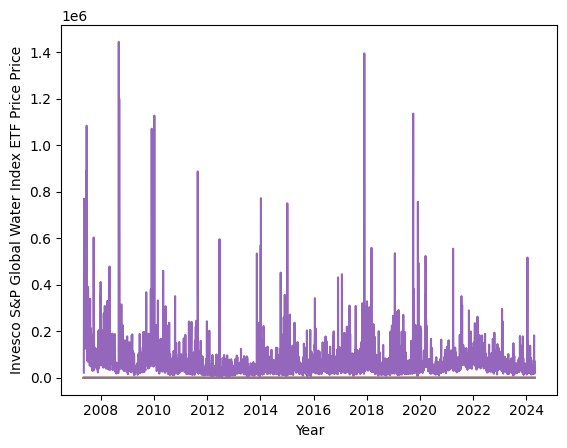

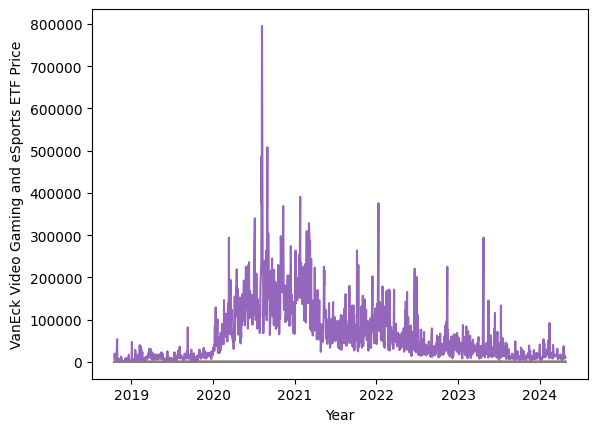

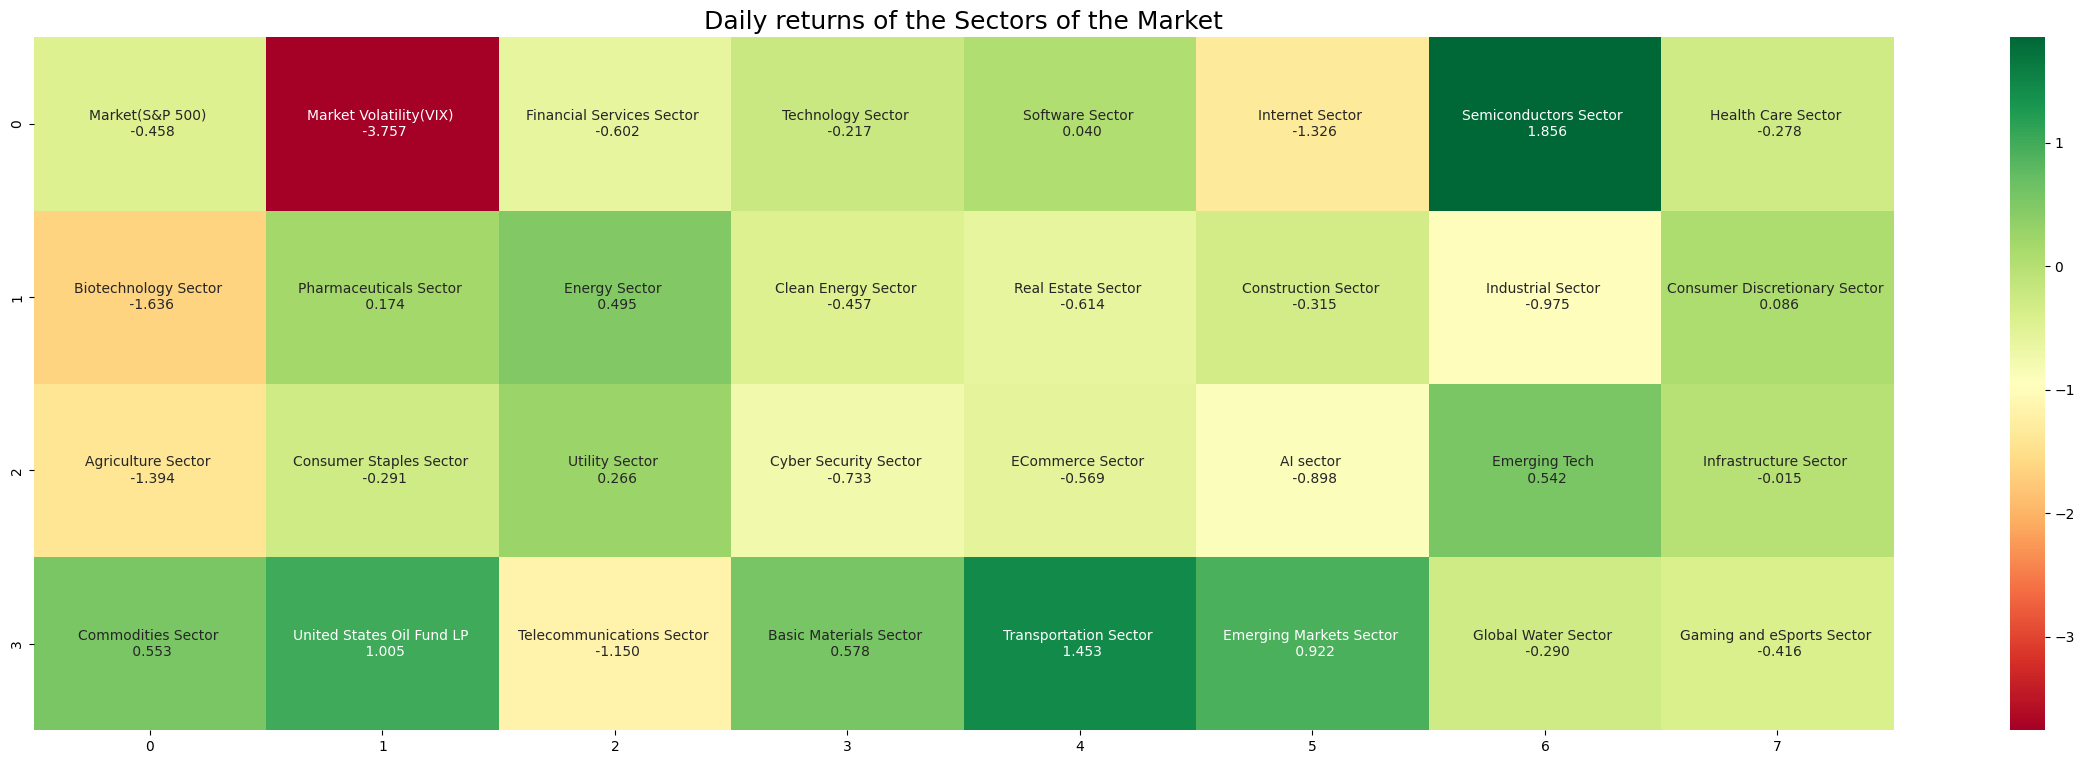

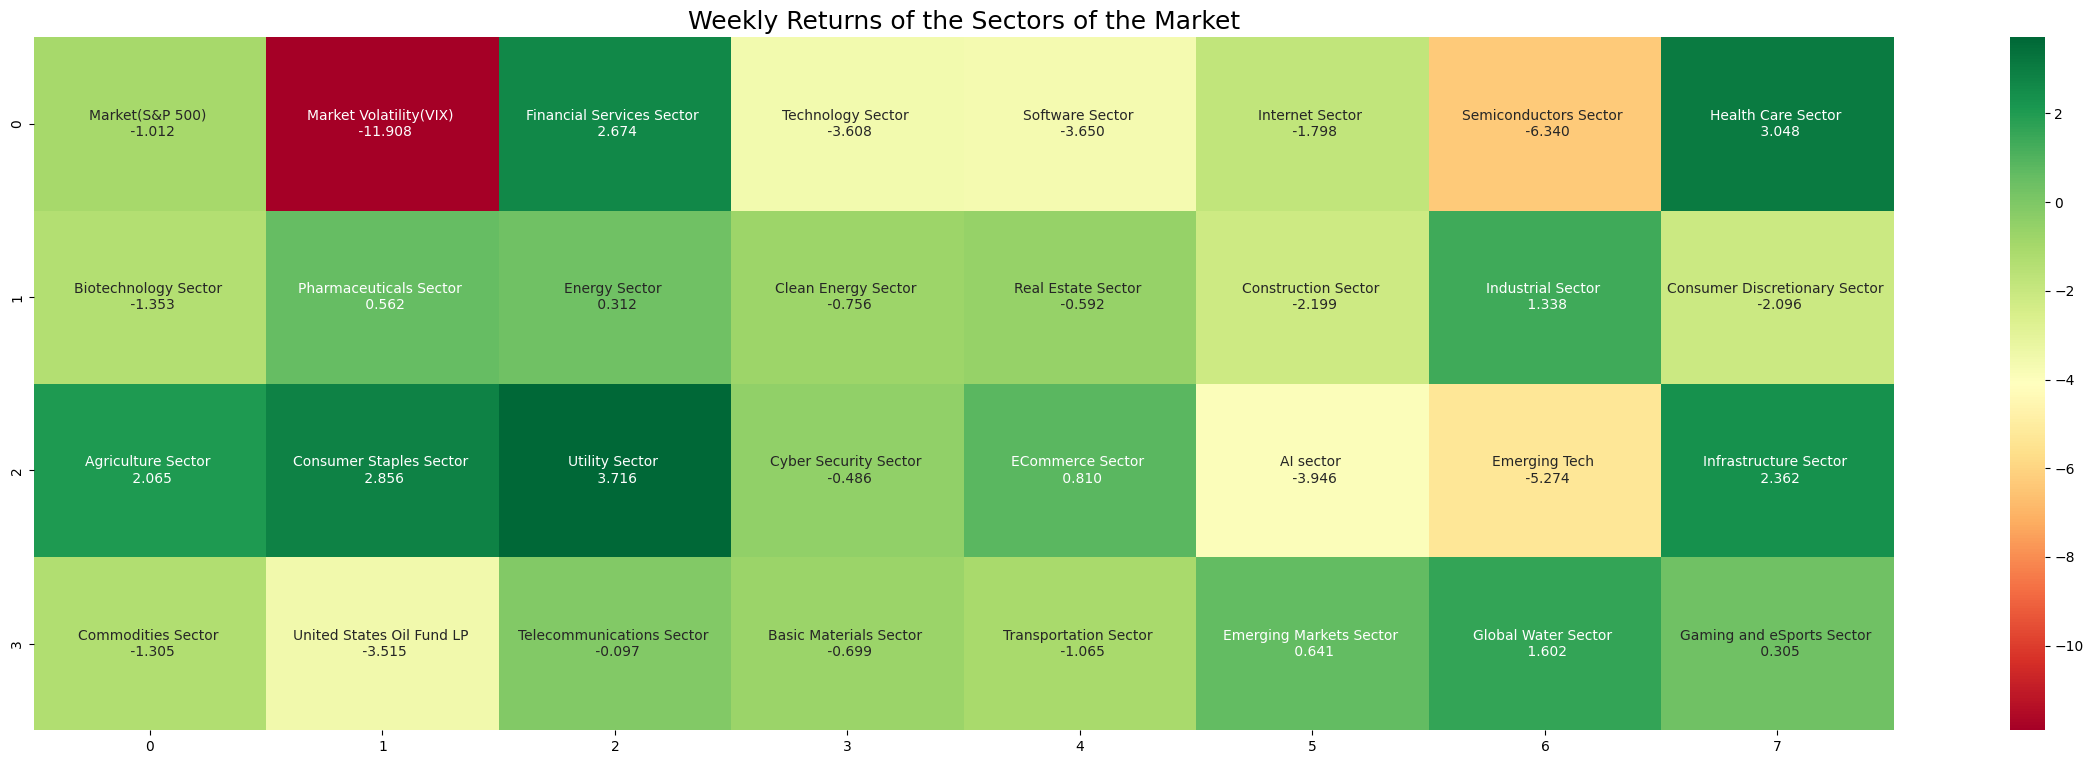

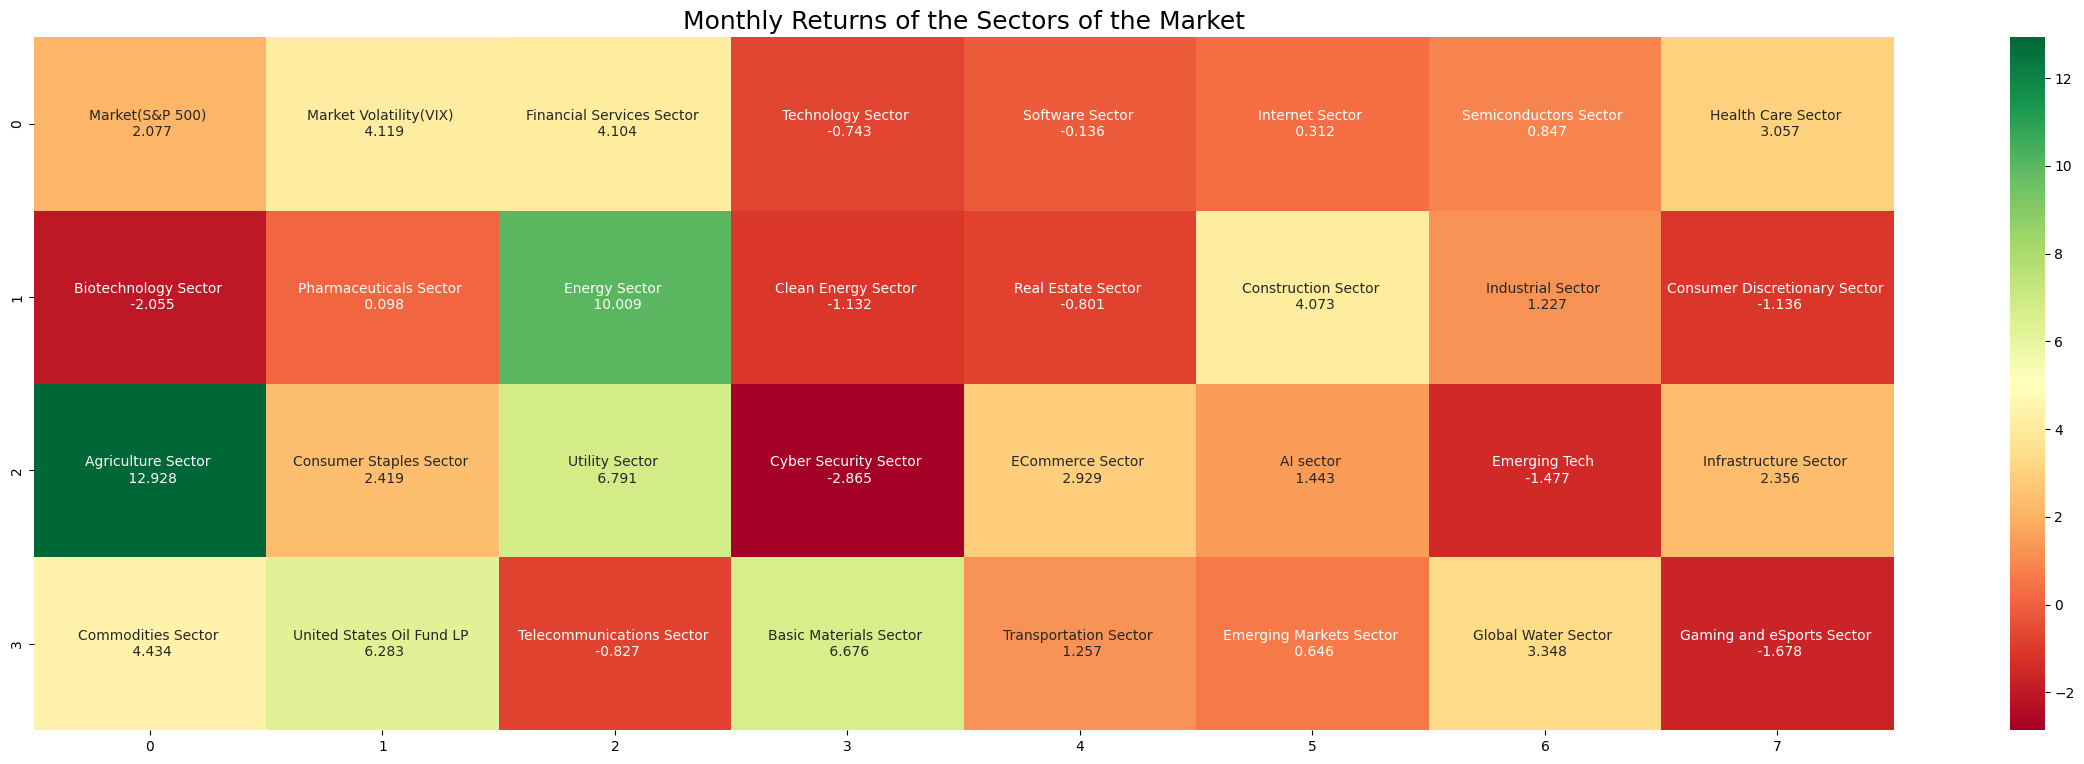

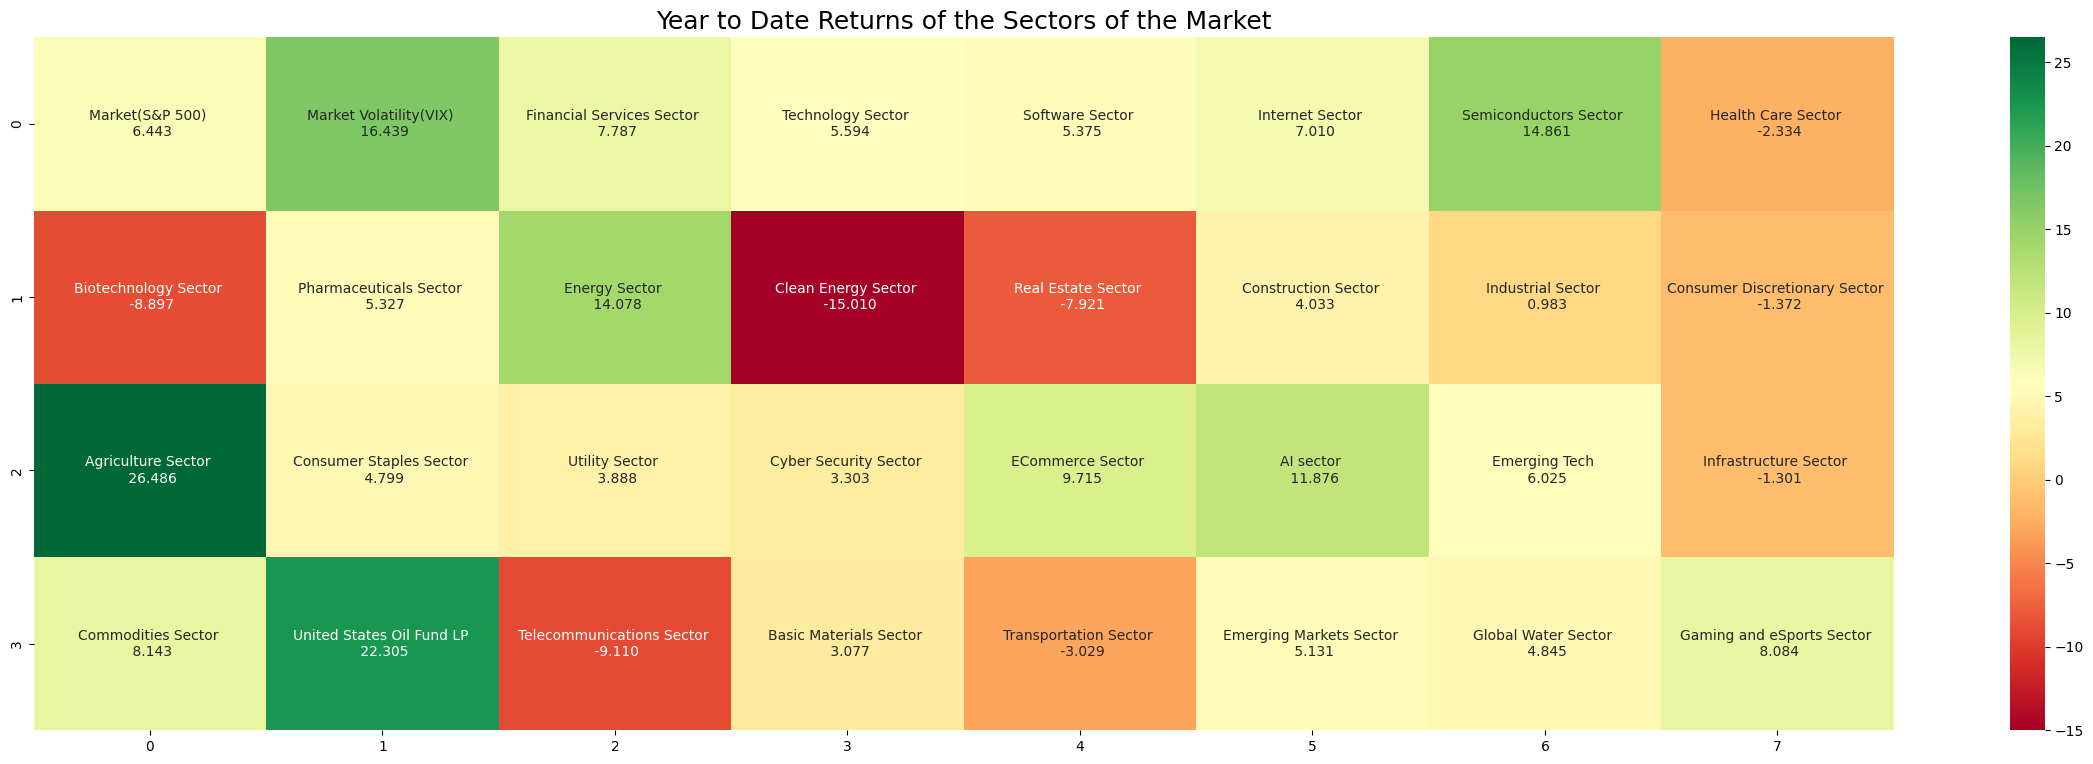

OSError: Cannot save file into a non-existent directory: 'C:\Users\mattp\Quant Finance\SMIF\Data Base\Sectors'

In [3]:
yo = SectorsOfTheMarket()